
# Proyecto ML (Airbnb Seattle) — Fase 2 — Comprensión de los Datos
**Asignatura:** Machine Learning (MLY0100)  
**Dataset:** Airbnb Seattle (Kaggle)  
**Ruta esperada de datos:** `data/01_raw/listings.csv`, `calendar.csv`, `reviews.csv`

> Este notebook sigue la rúbrica: 3 notebooks (uno por fase) y usa pandas, numpy, matplotlib, seaborn, plotly, scikit-learn.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
import os

print("CWD:", Path.cwd())

def locate_data_dir():
    # Busca data/01_raw en la carpeta actual y ascendiendo
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        cand = p / "data" / "01_raw"
        if cand.exists():
            return cand
    raise FileNotFoundError("No se encontró la carpeta data/01_raw en el cwd ni en sus carpetas padre.")

RAW = locate_data_dir()
LISTINGS = RAW / "listings.csv"
CALENDAR = RAW / "calendar.csv"
REVIEWS  = RAW / "reviews.csv"
# Comprobación útil
print("Usando datos desde:", RAW)
print("Existe listings?", LISTINGS.exists())
print("Existe calendar?", CALENDAR.exists())
print("Existe reviews?", REVIEWS.exists())
import pandas as pd
listings = pd.read_csv(LISTINGS, low_memory=False)
calendar = pd.read_csv(CALENDAR, parse_dates=["date"], low_memory=False)
reviews  = pd.read_csv(REVIEWS,  parse_dates=["date"], low_memory=False)


CWD: c:\Users\gabri\OneDrive\Escritorio\proyecto-kedro-fix\notebooks
Usando datos desde: C:\Users\gabri\OneDrive\Escritorio\proyecto-kedro-fix\data\01_raw
Existe listings? True
Existe calendar? True
Existe reviews? True


### Perfilado y nulos

In [8]:
# Función para perfilado rápido
def profile(df, name, top=10):
    print(f"== {name} ==")
    print("Shape:", df.shape)
    print("Duplicados:", df.duplicated().sum())
    miss = (df.isna().mean()*100).sort_values(ascending=False).round(2)
    print("Nulos más altos (%):")
    print(miss.head(top).astype(str) + "%")
    print()

profile(listings, "Listings")
profile(calendar, "Calendar")
profile(reviews, "Reviews")




== Listings ==
Shape: (3818, 92)
Duplicados: 0
Nulos más altos (%):
license                  100.0%
square_feet              97.46%
monthly_price            60.27%
security_deposit         51.13%
weekly_price             47.38%
notes                    42.06%
neighborhood_overview    27.03%
cleaning_fee             26.98%
transit                  24.46%
host_about                22.5%
dtype: object

== Calendar ==
Shape: (1393570, 4)
Duplicados: 0
Nulos más altos (%):
price         32.94%
listing_id      0.0%
date            0.0%
available       0.0%
dtype: object

== Reviews ==
Shape: (84849, 6)
Duplicados: 0
Nulos más altos (%):
comments         0.02%
listing_id        0.0%
id                0.0%
date              0.0%
reviewer_id       0.0%
reviewer_name     0.0%
dtype: object



### Distribuciones de precios

> Agregar bloque entrecomillado



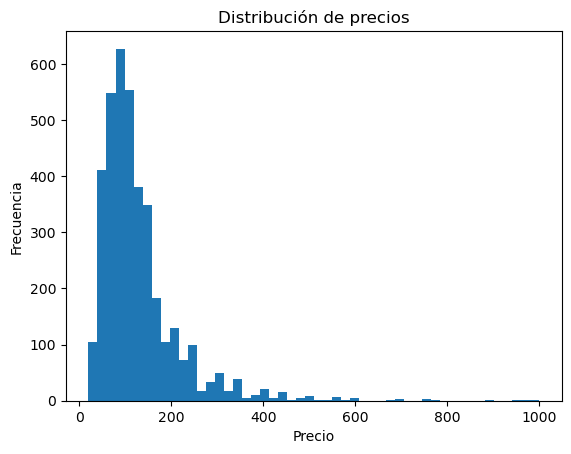

In [9]:

# Distribución de precios
def clean_price(s):
    if s.dtype == object:
        s = s.str.replace(r"[\$,]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

if "price" in listings.columns:
    listings["price_float"] = clean_price(listings["price"])
    plt.hist(listings["price_float"].dropna(), bins=50)
    plt.title("Distribución de precios")
    plt.xlabel("Precio")
    plt.ylabel("Frecuencia")
    plt.show()



# **Outliers en precios**


In [10]:
# Detección de outliers con IQR
Q1 = listings["price_float"].quantile(0.25)
Q3 = listings["price_float"].quantile(0.75)
IQR = Q3 - Q1
outliers = listings[(listings["price_float"] < (Q1 - 1.5*IQR)) |
                    (listings["price_float"] > (Q3 + 1.5*IQR))]

print("Número de outliers en precio:", outliers.shape[0])


Número de outliers en precio: 246


# **Relaciones bivariadas**

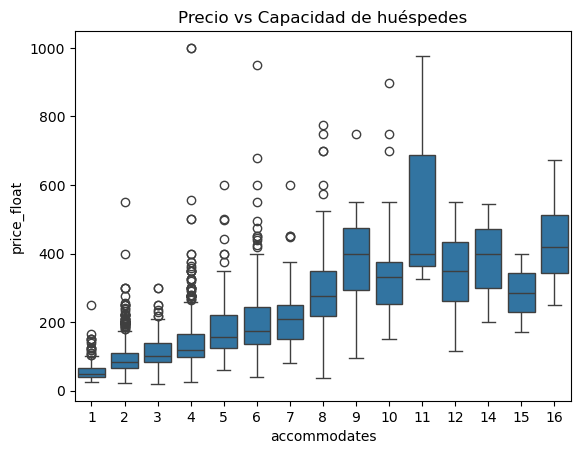

In [11]:
# Precio vs número de huéspedes
if "accommodates" in listings.columns:
    sns.boxplot(x="accommodates", y="price_float", data=listings)
    plt.title("Precio vs Capacidad de huéspedes")
    plt.show()

# Precio por tipo de habitación
if "room_type" in listings.columns:
    fig = px.box(listings, x="room_type", y="price_float", points="outliers")
    fig.show()


# Insights desde calendar.csv y **reviews**

Tasa de ocupación promedio: 32.94 %


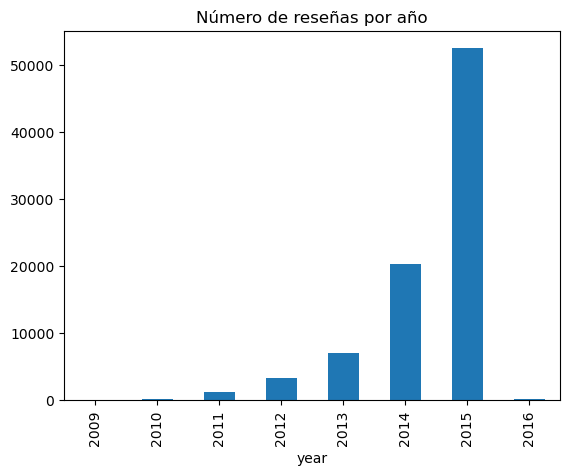

In [12]:
# Tasa de ocupación (calendar)
if "available" in calendar.columns:
    occ = (calendar["available"]=="f").mean()
    print("Tasa de ocupación promedio:", round(occ*100,2), "%")

# Cantidad de reseñas en el tiempo
if "date" in reviews.columns:
    reviews["year"] = reviews["date"].dt.year
    reviews_per_year = reviews.groupby("year").size()
    reviews_per_year.plot(kind="bar", title="Número de reseñas por año")
    plt.show()


### Correlaciones numéricas

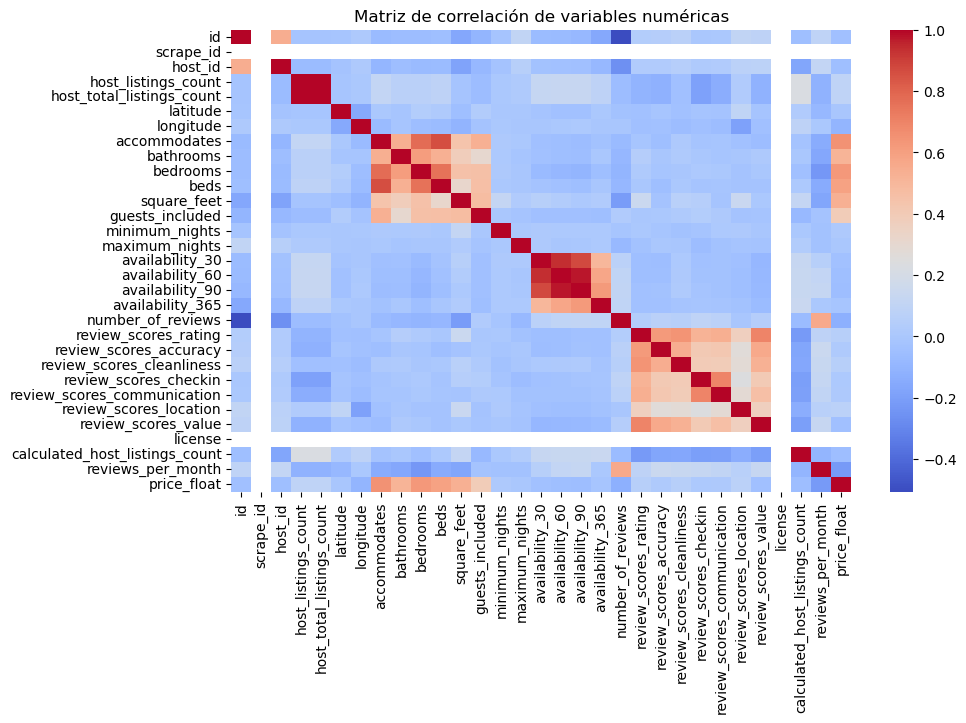

In [13]:
num_vars = listings.select_dtypes(include=[np.number])
corr = num_vars.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Matriz de correlación de variables numéricas')
plt.show()

### Análisis adicional de precios en el tiempo (calendar)

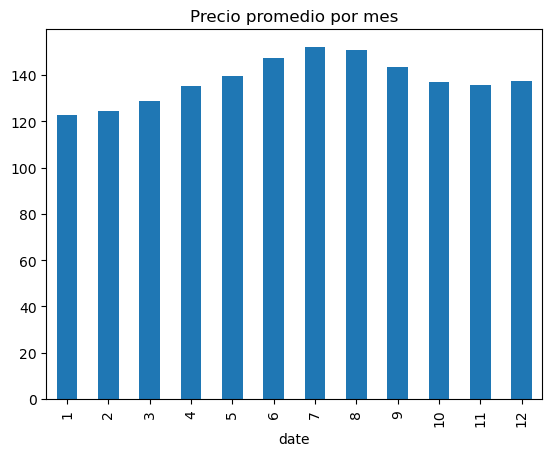

In [14]:
if 'price' in calendar.columns:
    calendar['price_float'] = clean_price(calendar['price'])
    avg_price_by_month = calendar.groupby(calendar['date'].dt.month)['price_float'].mean()
    avg_price_by_month.plot(kind='bar', title='Precio promedio por mes')
    plt.show()

### Conclusiones de Fase 2
- Se observan variables con alta cantidad de nulos (ej. `square_feet`, `monthly_price`).
- El precio presenta outliers significativos, lo que justifica aplicar transformaciones.
- La correlación muestra que `accommodates` y `bedrooms` tienen relación positiva con el precio.
- En calendar, se aprecian variaciones estacionales de precios.
- En reviews, el número de reseñas ha crecido con los años, lo que refleja mayor adopción de la plataforma.